In [1]:
from qaravan.core.hamiltonians import TFI
from qaravan.tensorQ.statevector_sim import StatevectorSim, all_zero_sv 
from qaravan.tensorQ.density_matrix_sim import DensityMatrixSim
from qaravan.core.noise import QubitNoise, PauliNoise, random_pauli_channel
from qaravan.core.gates import *
from qaravan.core.paulis import *

import matplotlib.pyplot as plt

# Inverting Pauli channels

In [2]:
# testing composition
nm1 = PauliNoise(['i', 'x'], [0.5, 0.5])
nm2 = PauliNoise(['i', 'y'], [0.5, 0.5])
print(nm1.compose(nm2))

{'z': np.float64(0.25), 'x': np.float64(0.25), 'y': np.float64(0.25), 'i': np.float64(0.25)}


In [3]:
nm = random_pauli_channel(4, 5, 0.1)
print(nm)
print(nm.pinv())
print(nm.compose(nm.pinv()))

{'iiii': np.float64(0.815), 'izyi': np.float64(0.025), 'yyyi': np.float64(0.019), 'zzzz': np.float64(0.075), 'zyzz': np.float64(0.066)}
{'iiii': np.float64(1.248), 'ixii': np.float64(0.019), 'iyyi': np.float64(-0.002), 'izyi': np.float64(-0.04), 'xixz': np.float64(0.005), 'xxxz': np.float64(0.006), 'xyzz': np.float64(-0.001), 'xzzz': np.float64(-0.0), 'yiii': np.float64(0.0), 'yxii': np.float64(0.002), 'yyyi': np.float64(-0.03), 'yzyi': np.float64(-0.001), 'zixz': np.float64(0.008), 'zxxz': np.float64(0.007), 'zyzz': np.float64(-0.103), 'zzzz': np.float64(-0.117)}
{'iiii': np.float64(1.0)}


In [4]:
nm.pinv().probs 

[np.float64(1.2483836273993267),
 np.float64(0.019025319363244718),
 np.float64(-0.0018210662944645878),
 np.float64(-0.040318479319020856),
 np.float64(0.00492837189053825),
 np.float64(0.005575592469256719),
 np.float64(-0.0005423036873476363),
 np.float64(-0.00048168568271674504),
 np.float64(0.00017249929237437601),
 np.float64(0.0019530710969557132),
 np.float64(-0.029819104213899314),
 np.float64(-0.00134971291948556),
 np.float64(0.0075316752713481625),
 np.float64(0.006657253130876015),
 np.float64(-0.10296265808708556),
 np.float64(-0.11693239970990041)]

# Error mitigation

In [2]:
n = 4
tfi = TFI(n, 1, 0.75) 
mag = [pauli_Z] * n
times = np.arange(0.1, 5.0, 0.1)

In [3]:
# first use propagator to evolve all_zero_sv for various and then pass mag to embed_operator and compute its expectation value in the evolved state
mag_list_exact = []
for time in times:
    init_state = all_zero_sv(n)
    final_state = tfi.evolve(time, init_state)
    mag_full_op = embed_operator(n, [0,1,2,3], mag)

    exp_val = final_state.conj().T @ mag_full_op @ final_state
    mag_list_exact.append(exp_val[0,0].real) 

In [4]:
# now use Trotter evolution with order 2 for the same times and compare the results
mag_list_trotter = []
for time in times:
    step_size = 0.1
    num_steps = int(time/step_size)
    #step_size = time/num_steps
    circ = tfi.trotter_circ(step_size, num_steps, order=2)
    sim = StatevectorSim(circ)
    exp_val = sim.local_expectation(mag)
    mag_list_trotter.append(exp_val)

[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 2]
[0, 3]
[0, 1, 2]
[0, 3, 4]
[0, 2, 3]
[0, 1]
[0, 4]
[0, 

In [5]:
nm_true = random_pauli_channel(4, 5, 0.02)

approx_probs = np.array(nm_true.probs) + np.random.normal(scale=1e-3, size=len(nm_true.probs))
approx_probs = approx_probs / np.sum(approx_probs)
nm_approx = PauliNoise(nm_true.strings, approx_probs)
nm_approx_inv = nm_approx.pinv()
nm_mod1 = nm_true.compose(nm_approx_inv)

approx_probs = np.array(nm_true.probs) + np.random.normal(scale=5e-3, size=len(nm_true.probs))
approx_probs = approx_probs / np.sum(approx_probs)
nm_approx = PauliNoise(nm_true.strings, approx_probs)
nm_approx_inv = nm_approx.pinv()
nm_mod2 = nm_true.compose(nm_approx_inv)

approx_probs = np.array(nm_true.probs) + np.random.normal(scale=1e-2, size=len(nm_true.probs))
approx_probs = approx_probs / np.sum(approx_probs)
nm_approx = PauliNoise(nm_true.strings, approx_probs)
nm_approx_inv = nm_approx.pinv()
nm_mod3 = nm_true.compose(nm_approx_inv)

In [6]:
mag_noisy = []
mag_corrected1 = []
mag_corrected2 = []
mag_corrected3 = []

for time in times:
    num_steps = 2
    #step_size = time/num_steps
    step_size = 0.1
    num_steps = int(time/step_size)
    circ = tfi.trotter_circ(step_size, num_steps, order=2)
    sim = DensityMatrixSim(circ, nm=nm_true)
    exp_val = sim.local_expectation(mag)
    mag_noisy.append(exp_val)

    sim = DensityMatrixSim(circ, nm=nm_mod1)
    exp_val = sim.local_expectation(mag)
    mag_corrected1.append(exp_val)

    sim = DensityMatrixSim(circ, nm=nm_mod2)
    exp_val = sim.local_expectation(mag)
    mag_corrected2.append(exp_val)

    sim = DensityMatrixSim(circ, nm=nm_mod3)
    exp_val = sim.local_expectation(mag)
    mag_corrected3.append(exp_val)

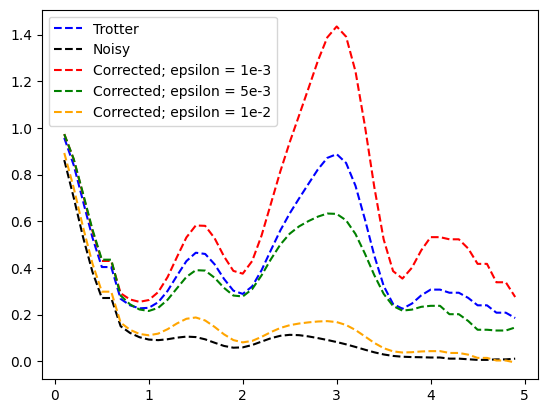

In [7]:
plt.plot(times, mag_list_trotter, label='Trotter', color='blue', linestyle='--')
plt.plot(times, mag_noisy, label='Noisy', color='black', linestyle='--')
plt.plot(times, mag_corrected1, label='Corrected; epsilon = 1e-3', color='red', linestyle='--')
plt.plot(times, mag_corrected2, label='Corrected; epsilon = 5e-3', color='green', linestyle='--')
plt.plot(times, mag_corrected3, label='Corrected; epsilon = 1e-2', color='orange', linestyle='--')
plt.legend()

In [ ]:
import pickle
with open("4_data.pickle", "wb") as f:
    pickle.dump([times, mag_list_exact, mag_list_trotter, mag_noisy, mag_corrected1, mag_corrected2, mag_corrected3], f)

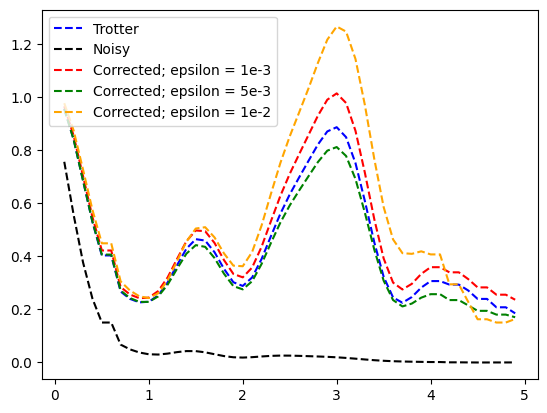

In [152]:
plt.plot(times, mag_list_trotter, label='Trotter', color='blue', linestyle='--')
plt.plot(times, mag_noisy, label='Noisy', color='black', linestyle='--')
plt.plot(times, mag_corrected1, label='Corrected; epsilon = 1e-3', color='red', linestyle='--')
plt.plot(times, mag_corrected2, label='Corrected; epsilon = 5e-3', color='green', linestyle='--')
plt.plot(times, mag_corrected3, label='Corrected; epsilon = 1e-2', color='orange', linestyle='--')
plt.legend()

In [ ]:
mag_corrected1

[np.float64(0.9651526838068456),
 np.float64(0.9651526838068456),
 np.float64(0.8533303166120524),
 np.float64(0.6994578675000482),
 np.float64(0.5432886448179439),
 np.float64(0.41559434090314284),
 np.float64(0.3287399845128273),
 np.float64(0.27791177131564215),
 np.float64(0.2508373381845191),
 np.float64(0.2390991107899501),
 np.float64(0.24373844736491299),
 np.float64(0.2719357182810501),
 np.float64(0.32754650514674655),
 np.float64(0.40242998396467794),
 np.float64(0.47520580646459065),
 np.float64(0.5194541305519453),
 np.float64(0.5172598277110853),
 np.float64(0.4702083705054052),
 np.float64(0.40091868640935574),
 np.float64(0.34349704357226785),
 np.float64(0.32778498999133476),
 np.float64(0.36601735198011237),
 np.float64(0.44916635408581307),
 np.float64(0.5545528705810361),
 np.float64(0.6596582401171209),
 np.float64(0.7535080869665656),
 np.float64(0.8387303862096016),
 np.float64(0.9234020433510453),
 np.float64(1.0084237397485676),
 np.float64(1.079282385941119),


In [154]:
err_noisy = [np.abs(a-b) for a, b in zip(mag_noisy, mag_list_trotter)]
err_corrected1 = [np.abs(a-b) for a, b in zip(mag_corrected1, mag_list_trotter)]
err_corrected2 = [np.abs(a-b) for a, b in zip(mag_corrected2, mag_list_trotter)]
err_corrected3 = [np.abs(a-b) for a, b in zip(mag_corrected3, mag_list_trotter)]

Text(0.5, 0, 'evolution time')

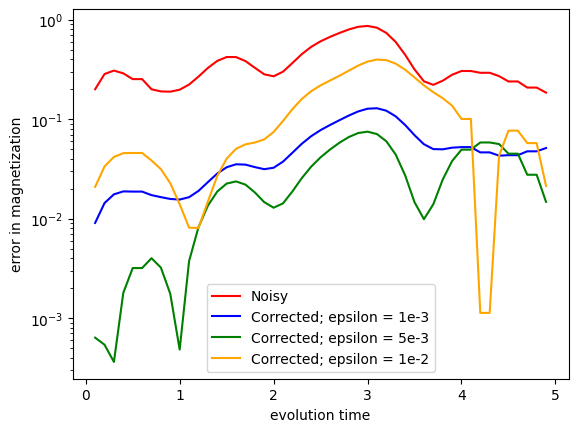

In [155]:
plt.plot(times, err_noisy, label='Noisy', color='red')
plt.plot(times, err_corrected1, label='Corrected; epsilon = 1e-3', color='blue')
plt.plot(times, err_corrected2, label='Corrected; epsilon = 5e-3', color='green')
plt.plot(times, err_corrected3, label='Corrected; epsilon = 1e-2', color='orange')
plt.legend()
plt.yscale('log')
plt.ylabel('error in magnetization')
plt.xlabel('evolution time')

# Old

In [ ]:
def new_inv(nm): 
    ptm = nm.ptm()
    sm = nm.symp_matrix(full=True)
    probs = np.linalg.inv(sm) @ (1/np.diag(ptm))
    return PauliNoise(['i', 'x', 'y', 'z'], probs)

In [ ]:
# now let's do thermal noise (first without compilation, so all 2 qubit gates with have 1-qubit gate times) 
t1 = 100
t2 = 200
one_qubit_time = 1
two_qubit_time = 5
nm = QubitNoise(t1, t2, one_qubit_time, two_qubit_time)

mag_list_thermal = []
for time in times:
    num_steps = 2
    step_size = time/num_steps
    circ = tfi.trotter_circ(step_size, num_steps, order=2)
    sim = DensityMatrixSim(circ, nm=nm)
    exp_val = sim.local_expectation(mag)
    mag_list_thermal.append(exp_val)